<a href="https://colab.research.google.com/github/hanamahes78/F-NST_Fashion_Design/blob/main/F_NST_Fashion_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision Pillow av transformers

In [ ]:
import torch
from collections import namedtuple
from torchvision import models, transforms
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from PIL import Image
import os
import tqdm
import argparse
import numpy as np
import av
import matplotlib.pyplot as plt
import cv2
import requests

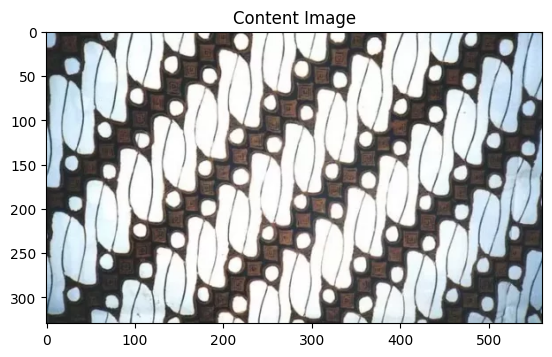

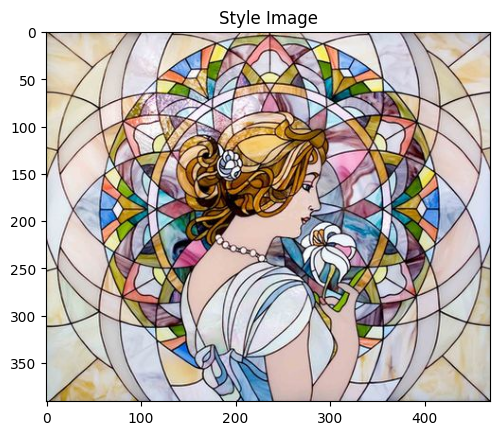

In [ ]:
# Load the images
content_url = "https://cdnwpseller.gramedia.net/wp-content/uploads/2023/02/Gambar-Batik-Parang-Kusumo.jpg-561x330.webp"
style_path = "/content/drive/MyDrive/image/img/styles/mosaic.jpg"

def download_and_save_image(content_url, save_path):
    # Download the image
    response = requests.get(content_url, stream=True)
    response.raise_for_status()

    # Open and save the image
    with open(save_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

# Define the save path and file name
save_path = "content.png"

# Download and save the image
download_and_save_image(content_url, save_path)

# Read and display the content image
content = cv2.imread(save_path)
content = cv2.cvtColor(content, cv2.COLOR_BGR2RGB)
plt.imshow(content)
plt.title('Content Image')
plt.show()

# Read and display the style image
style = cv2.imread(style_path)
style = cv2.cvtColor(style, cv2.COLOR_BGR2RGB)
plt.imshow(style)
plt.title('Style Image')
plt.show()

In [ ]:
# Mean and standard deviation used for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def gram_matrix(y):
    """ Returns the gram matrix of y (used to compute style loss) """
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram


def train_transform(image_size):
    """ Transforms for training images """
    transform = transforms.Compose(
        [
            transforms.Resize(int(image_size * 1.15)),
            transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    return transform


def style_transform(image_size=None):
    """ Transforms for style image """
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(
        resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform


def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors


def deprocess(image_tensor):
    """ Denormalizes and rescales image tensor """
    image_tensor = denormalize(image_tensor)[0]
    image_tensor *= 255
    image_np = torch.clamp(image_tensor, 0, 255).cpu().numpy().astype(np.uint8)
    image_np = image_np.transpose(1, 2, 0)
    return image_np

In [ ]:
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple(
            "VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out


class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 32, kernel_size=9, stride=1),
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            ConvBlock(32, 3, kernel_size=9, stride=1,
                      normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)


class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3,
                      stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3,
                      stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(
                kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(
            out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x

Namespace(image_path='/content/content.png', checkpoint_model='/content/drive/MyDrive/image/img/styles/mosaic_10000.pth')


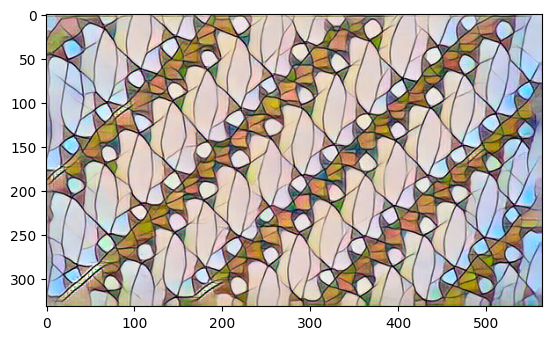

In [ ]:
if __name__ == "__main__":
    # Set the image_path and checkpoint_model directly
    args = argparse.Namespace(
        image_path="/content/content.png",
        checkpoint_model="/content/drive/MyDrive/image/img/styles/mosaic_10000.pth"
    )
    print(args)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = style_transform()

    # Define model and load model checkpoint
    transformer = TransformerNet().to(device)
    transformer.load_state_dict(torch.load(
        args.checkpoint_model, map_location=torch.device('cpu')))
    transformer.eval()

    # Prepare input
    image_tensor = Variable(transform(Image.open(args.image_path))).to(device)
    image_tensor = image_tensor.unsqueeze(0)

    # Stylize image
    with torch.no_grad():
        stylized_image = denormalize(transformer(image_tensor)).cpu()

    # Save stylized image using PyTorch's save_image
    stylized_path = "stylized.png"
    save_image(stylized_image, stylized_path)

    # Read the stylized image using OpenCV
    stylized = cv2.imread(stylized_path)
    stylized = cv2.cvtColor(stylized, cv2.COLOR_BGR2RGB)

    # Display the stylized image using Matplotlib
    plt.imshow(stylized)
    plt.show()

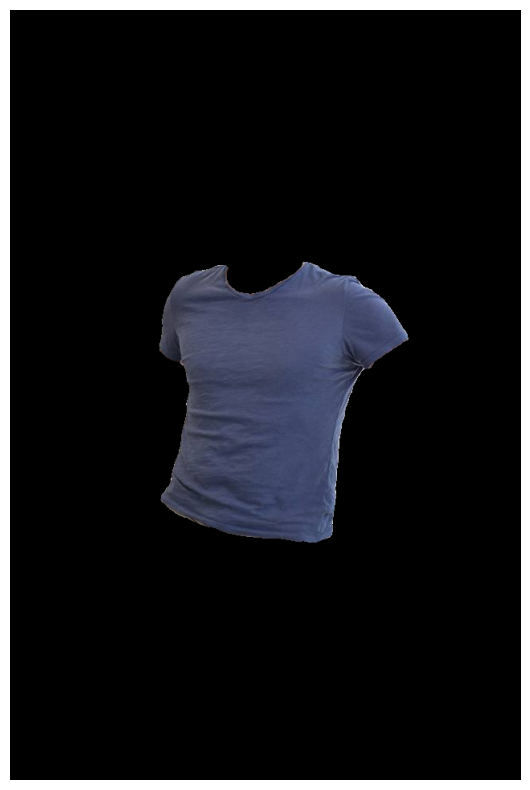

In [ ]:
# Load the pre-trained Segformer model and processor
processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

def download_and_save_image(url, save_path):
    # Download the image
    response = requests.get(url, stream=True)
    response.raise_for_status()

    # Open and save the image
    with open(save_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

# Provide a valid direct image URL
url = "https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg"
# url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"
# url = "https://asset.kompas.com/crops/uWy9sjOHu_N21k29z9PxyS63OPg=/0x0:1000x667/1200x800/data/photo/2022/05/04/6271c5c7d49c9.jpg"
# url = "https://d1vbn70lmn1nqe.cloudfront.net/prod/wp-content/uploads/2023/01/05082857/Mudah-Ini-Cara-Mengatasi-Cegukan-pada-Orang-Dewasa.jpg.webp"

# Define the save path and file name
save_path = "model.png"

# Download and save the image
download_and_save_image(url, save_path)

# Load and process the image
image = Image.open(save_path)
inputs = processor(images=image, return_tensors="pt")

# Perform segmentation
outputs = model(**inputs)
logits = outputs.logits.cpu()

# Upsample the segmentation map to match the image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# Obtain the predicted segmentation mask
pred_seg = upsampled_logits.argmax(dim=1)[0]

# Label yang sesuai dengan pakaian adalah "Upper-clothes" (label 4)
clothes_label = 4

# Buat mask untuk mengidentifikasi pakaian
clothes_mask = (pred_seg == clothes_label)

# Terapkan mask ke gambar asli
image_with_clothes = image.copy()
image_with_clothes.putdata([image.getpixel((x, y)) if clothes_mask[y, x] else (0, 0, 0) for y in range(image.height) for x in range(image.width)])

# Tampilkan gambar dengan pakaian
plt.figure(figsize=(10, 10))
plt.imshow(image_with_clothes)
plt.axis("off")

plt.show()

# Simpan gambar dengan pakaian ke file
image_with_clothes.save("/content/segmented_clothes.png")

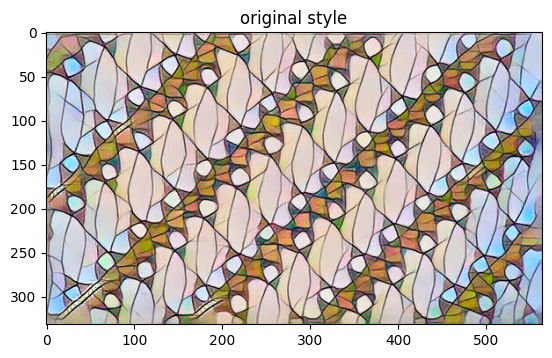

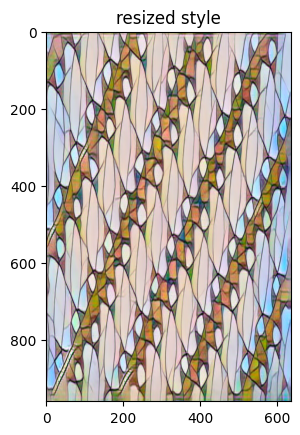

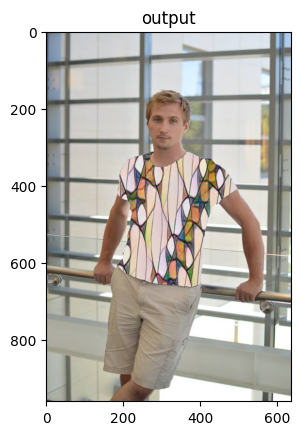

In [ ]:
# Load the images
gambar1 = cv2.imread("/content/stylized.png") #style img
gambar2 = cv2.imread("/content/segmented_clothes.png")  # segmen img

# Get the size of gambar2
target_size = (gambar2.shape[1], gambar2.shape[0])

# Resize gambar1 to the size of gambar2
gambar1_resized = cv2.resize(gambar1, target_size)

# Display ori and resized images
ori_sty = cv2.cvtColor(gambar1, cv2.COLOR_BGR2RGB)
plt.imshow(ori_sty)
plt.title('original style')
plt.show()

resize_sty = cv2.cvtColor(gambar1_resized, cv2.COLOR_BGR2RGB)
plt.imshow(resize_sty)
plt.title('resized style')
plt.show()

# Konversi ke grayscale
gray_gambar1 = cv2.cvtColor(gambar1_resized, cv2.COLOR_BGR2GRAY)
gray_gambar2 = cv2.cvtColor(gambar2, cv2.COLOR_BGR2GRAY)

# Temukan kontur di gambar 2
contours, _ = cv2.findContours(gray_gambar2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ambil kontur terbesar
largest_contour = max(contours, key=cv2.contourArea)

# Buat mask dari kontur terbesar
mask = np.zeros_like(gray_gambar2)
cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

# Crop gambar1 sesuai dengan mask
gambar1_cropped = cv2.bitwise_and(gambar1_resized, gambar1_resized, mask=mask)

# Tambahkan alpha channel ke gambar1_cropped
gambar1_with_alpha = cv2.cvtColor(gambar1_cropped, cv2.COLOR_BGR2BGRA)

# Setel piksel hitam (0, 0, 0) menjadi piksel transparan
black_pixels = (gambar1_cropped == [0, 0, 0]).all(axis=2)
gambar1_with_alpha[black_pixels] = [0, 0, 0, 0]

# Hitung posisi (x, y) untuk menempelkan gambar1 pada gambar2
x, y = 0, 0

# Buat salinan gambar2 dengan alpha channel
output = gambar2.copy()
output = cv2.cvtColor(output, cv2.COLOR_BGR2BGRA)

# Tempelkan gambar1_with_alpha pada output
output[y:y+gambar1_with_alpha.shape[0], x:x+gambar1_with_alpha.shape[1]] = gambar1_with_alpha

# Load model img
gambar3 = Image.open("/content/model.png")

# Convert output to PIL Image
output_pil = Image.fromarray(cv2.cvtColor(output, cv2.COLOR_BGRA2RGBA))

# Tempelkan gambar1 ke gambar2
gambar3.paste(output_pil, (x, y), output_pil)

# Simpan gambar hasil
gambar3.save("/content/final.png")

# Show the result using matplotlib
plt.imshow(np.array(gambar3))  # Convert back to numpy array for matplotlib
plt.title("output")
plt.show()